In [3]:
example_description = """
Liposomal Encapsulation of Existing Cancer Drugs

Many existing chemotherapeutic drugs used to treat cancer have poor solubility, low bioavailability, and high systemic toxicity. A novel drug reformulation strategy is proposed to encapsulate these drugs within liposomes to improve their pharmacokinetic profile and therapeutic index.

Liposomes are spherical lipid vesicles consisting of one or more bilayers surrounding an aqueous core. Their hydrophobic membrane and aqueous inner cavity allow them to carry both lipophilic and hydrophilic drug compounds. Liposomes can protect encapsulated drugs from degradation, reduce interactions with blood components, and alter drug distribution in the body.

In this approach, liposomes composed of phospholipids like phosphatidylcholine will be prepared. The antineoplastic agent will be dissolved in an organic solvent and added to the liposome solution, becoming integrated into the lipid bilayer. An active loading method can also be used in which a gradient is created to load the drug into the liposome interior.

The liposomal encapsulation aims to increase the circulation time of the drug in the bloodstream by evading rapid renal clearance and degradation. It will also facilitate preferential accumulation of the drug at the tumor site due to the enhanced permeability and retention effect. The liposomes will hopefully minimize exposure of healthy tissues, improving the therapeutic index.

In vivo studies in animal models will evaluate the pharmacokinetics, biodistribution, toxicity, and efficacy of the liposomal formulation compared to the free drug. If successful, this novel reformulation approach could significantly improve the clinical utility of existing antineoplastic agents.
"""

In [7]:
from clients.documents import find_buyers
res = await find_buyers(example_description)
results = res.buyers

INFO:httpx:HTTP Request: POST http://localhost:53928/ "HTTP/1.1 200 OK"
INFO:clients.documents.patents.buyer_finder:Find took 22.09 seconds (123)


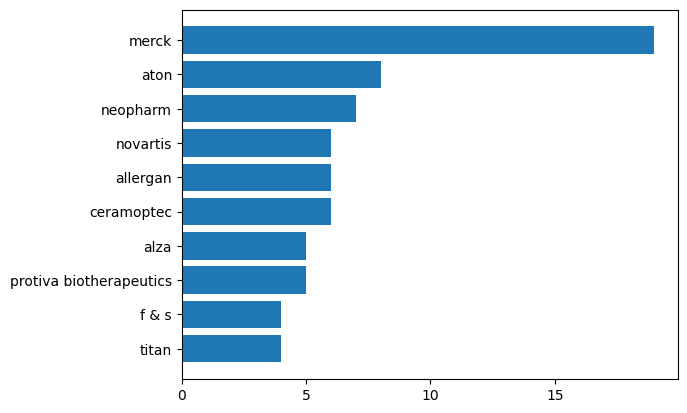

In [8]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
import polars as pl

df = pl.DataFrame(results).sort(by="count", descending=True)
assignees: list[str] = df["name"].to_list()[0:10]
counts = df["count"].to_list()[0:10]

ax.xaxis.get_major_locator().set_params(integer=True)
ax.barh(assignees, counts)
ax.invert_yaxis()

plt.show()



In [9]:
pdf = df.sort(by="score", descending=True).to_pandas()
pdf.style
display(pdf)
import dataframe_image as dfi
# dfi.export(pdf, 'df_styled.png')


INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,id,name,ids,count,titles,min_age,avg_age,max_relevance_score,avg_relevance_score,score
0,1198,merck,"[WO-2012044638-A1, WO-2009002495-A1, WO-201205...",19,[Low molecular weight cationic lipids for olig...,12,16.0,0.989429,0.991341,0.59
1,3340,jazz,"[WO-2019028340-A9, WO-2021174039-A1, WO-201902...",3,[Formulations comprising a nucleic acid in a h...,4,6.0,0.987192,0.987532,0.43
2,14398,merrimack,"[WO-2017031442-A1, WO-2017161067-A1, WO-201703...",3,[Combination therapy using liposomal irinoteca...,8,9.0,0.988500,0.989769,0.34
3,1879,biogen,"[WO-2022212648-A1, WO-2014110440-A1]",2,[Nucleic acid delivery to the central nervous ...,3,7.0,0.989786,0.992620,0.34
4,12670,translate bio,"[WO-2022221688-A1, WO-2018089846-A1]",2,"[&#34;good&#34;buffer-based cationic lipids, S...",3,6.0,0.987882,0.991202,0.34
...,...,...,...,...,...,...,...,...,...,...
118,4656,ltt,[WO-2004084871-A1],1,[Intravenous nanoparticles for targenting drug...,21,21.0,0.986590,0.986590,0.00
119,4668,dabur,[WO-2004056387-A1],1,[Synthetic peptide analogs for the treatment o...,22,22.0,0.986085,0.986085,0.00
120,4680,labopharm,[WO-02100529-A1],1,[Unimolecular polymeric micelles with an ioniz...,23,23.0,0.987812,0.987812,0.00
121,4747,procyon,[WO-03039576-A1],1,[Psp-94: use for treatment of hypercalcemia an...,23,23.0,0.986614,0.986614,0.00
